## Facebook-combined data: The Analysis

### Importing data and incorporating it into graph data mathematically

Graph with 4039 nodes and 88234 edges


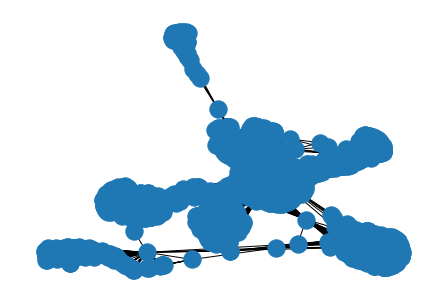

In [4]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network

# we have to take the data from existing file on local system
kn = nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype=int)

print(kn)
nx.draw(kn, pos=nx.spring_layout(kn))

In [ ]:
data = pd.read_csv("facebook_combined.txt", sep=" ", header=None)
data.columns = ["person1", "person2"]

sample = data.sample(1000, random_state=1)

net = Network(notebook=True, cdn_resources="remote", bgcolor="#222222", font_color="white", height="750px", width="100%")

nodes = list(set([*sample.person1, *sample.person2]))   # data == sample
edges = sample.values.tolist()   # data === sample
net.add_nodes(nodes)
net.add_edges(edges)
net.show('graph.html')

### Graph representation to Adjacency matrix and Laplacian matrix

In [10]:
adjM = nx.adjacency_matrix(kn, weight=1)   # assigning the edge weight to 1
# print('Adjacency matrix: \n', adjM.todense())

L = nx.laplacian_matrix(kn, weight=1).astype(float)  # assigning the edge weight to 1
# print('Laplacian matrix: \n', L.todense())

### Feature extraction: Node degree, degree centrality, Eigenvector centrality and Betweenness Centrrality

In [7]:
node_degree = kn.degree
# print(kn.degree,'\n\n')

graphs = [kn]

deg_cen = {}

for g in graphs:
    deg_cen[g] = nx.degree_centrality(g)

# print('Degree Centrality: ')
# print(deg_cen[g],'\n\n')

bet_cen = {}

for g in graphs:
    bet_cen[g] = nx.betweenness_centrality(g, normalized=True, endpoints=True)

# print('Betweenness Centrality: ')
# print(bet_cen[g], '\n\n')

eig_cen = {}

for g in graphs:
    eig_cen[g] = nx.eigenvector_centrality(g)

# print('Eigenvector centrality: ')
# print(eig_cen[g], '\n\n')

print("Sorted betweenness centrality nodeIDs : ", sorted(bet_cen[g], key=bet_cen[g].get, reverse=True)[:7])
print("Sorted degree      centrality nodeIDs : ", sorted(deg_cen[g], key=deg_cen[g].get, reverse=True)[:7])
print("Sorted eigenvector centrality nodeIDs : ", sorted(eig_cen[g], key=eig_cen[g].get, reverse=True)[:7])



Sorted betweenness centrality nodeIDs :  [107, 1684, 3437, 1912, 1085, 0, 698]
Sorted degree      centrality nodeIDs :  [107, 1684, 1912, 3437, 0, 2543, 2347]
Sorted eigenvector centrality nodeIDs :  [1912, 2266, 2206, 2233, 2464, 2142, 2218]


### Understanding variability with degree and betweenness centrality

(-1.1853339198231698,
 0.9504195573925973,
 -1.1603213974833488,
 1.1884261199831962)

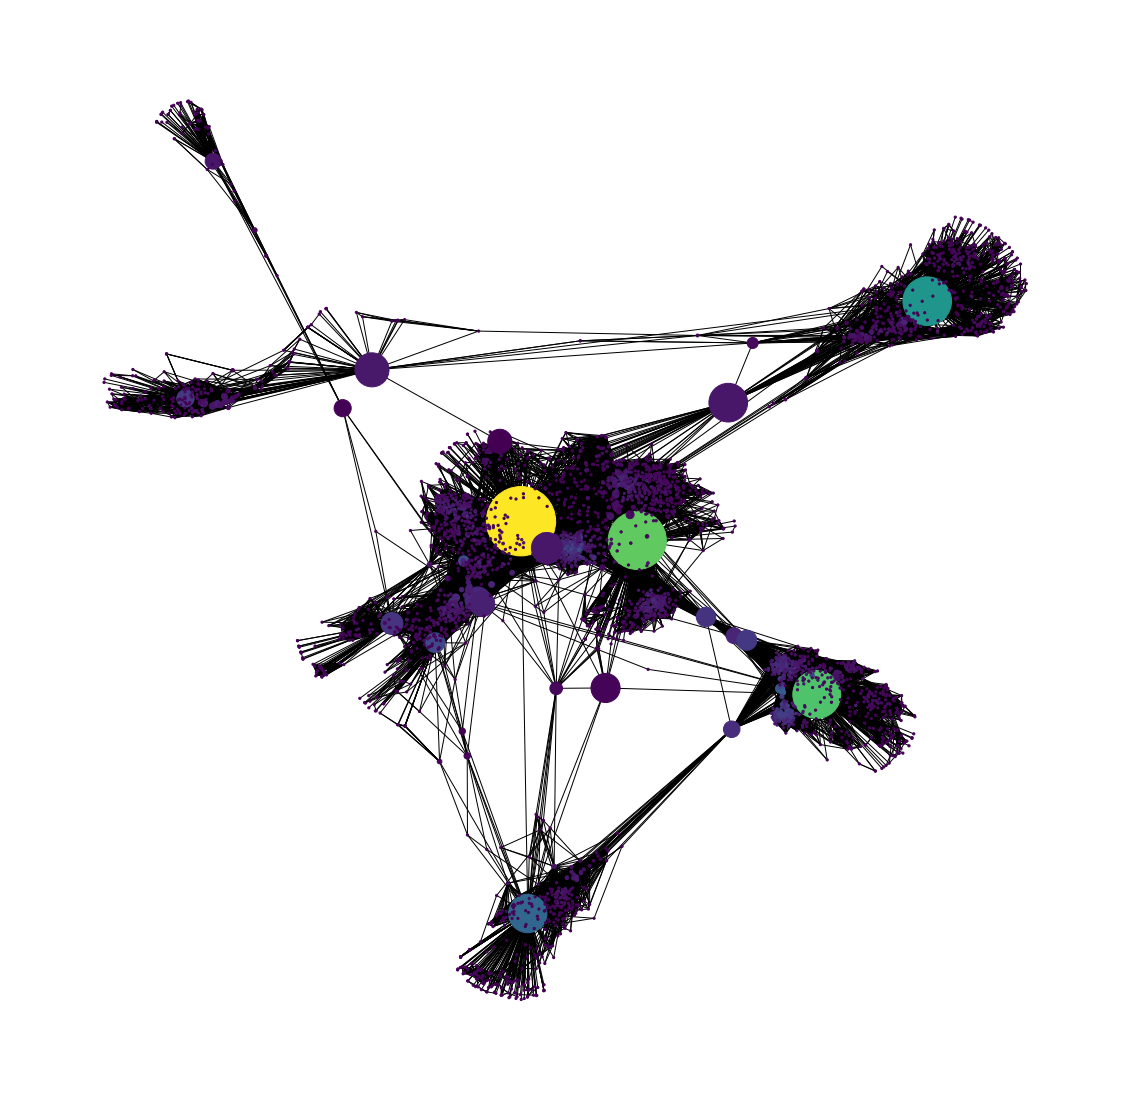

In [8]:
pos = nx.spring_layout(kn)
node_color = [20000.0 * kn.degree(v) for v in kn]
node_size =  [v * 10000 for v in bet_cen[g].values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(kn, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

### Clustering: K-means

Clusters: [0 0 0 ... 1 1 1]


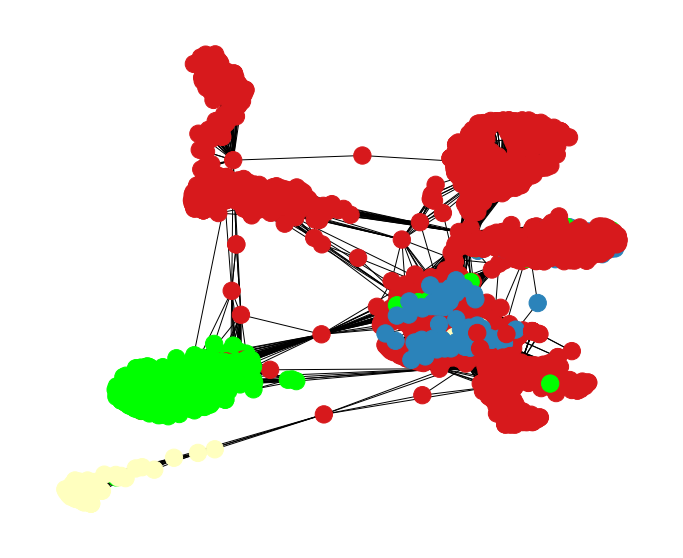

In [12]:
vals, vecs = np.linalg.eig(L.todense())
vals = vals.real
vecs = vecs.real

from sklearn.cluster import KMeans

# sort these based on the eigenvalues
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

# kmeans on first four vectors with nonzero eigenvalues
kmeans = KMeans(n_clusters=4)
kmeans.fit(vecs[:,1:4])
labels = kmeans.labels_
print("Clusters:", labels)
fig = plt.subplots(1, figsize=(12,10))
colors = ['#d7191c', '#ffffbf', '#2b83ba', '#00FF00']
node_colors = [ colors[labels[v]] for v in kn.nodes()]
nx.draw(kn, node_color=node_colors, with_labels=False)

### Clustering: Agglomerative clustering

Clusters: [0 0 0 ... 2 2 2]


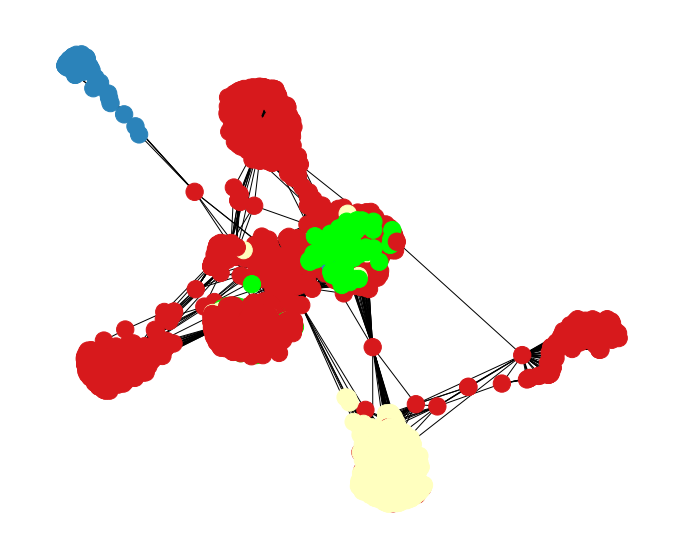

In [14]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative clustering on first four vectors with nonzero eigenvalues
aggCl = AgglomerativeClustering(n_clusters=4)
aggCl.fit(vecs[:,1:4])
labels = aggCl.labels_
print("Clusters:", labels)
fig = plt.subplots(1, figsize=(12,10))
colors = ['#d7191c', '#ffffbf', '#2b83ba', '#00FF00']
node_colors = [ colors[labels[v]] for v in kn.nodes()]
nx.draw(kn, node_color=node_colors, with_labels=False)

Clusters: [0 0 0 ... 0 0 0]


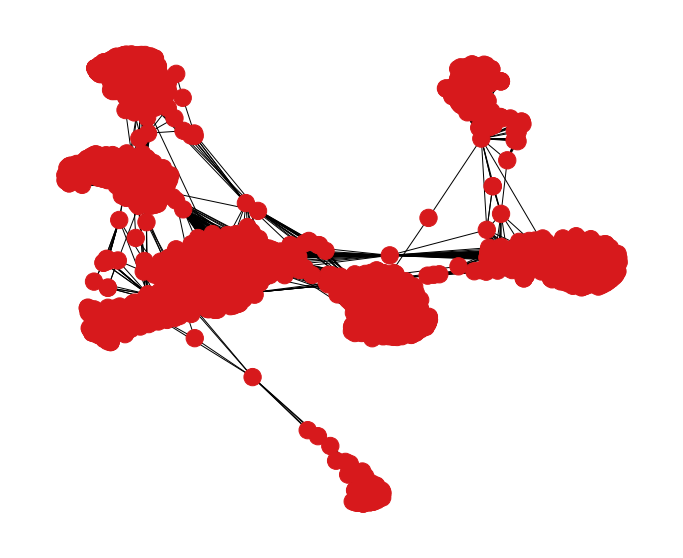

In [21]:
from sklearn.cluster import DBSCAN

# kmeans on first three vectors with nonzero eigenvalues
dbscan = DBSCAN(eps=0.5)
dbscan.fit(vecs[:,1:4])
labels = dbscan.labels_
print("Clusters:", labels)
fig = plt.subplots(1, figsize=(12,10))
colors = ['#d7191c', '#ffffbf', '#2b83ba', '#00FF00']
node_colors = [ colors[labels[v]] for v in kn.nodes()]
nx.draw(kn, node_color=node_colors, with_labels=False)

### Evaluation metrics: Silhouette score, Calinski-Harasz index and Davies-Bouldin score

In [15]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score

In [16]:
se = [] 
sil_scores = []
calinski_score = []
davies_score = []
index = range(2, 10)
for i in index:
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(vecs[:,1:i])
    se.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(vecs[:,1:i], labels))
    calinski_score.append(calinski_harabasz_score(vecs[:,1:i], labels))
    davies_score.append(davies_bouldin_score(vecs[:,1:i], labels))

    print('With in sum of squared error (WCSS) at K =', i, ':', kmeans.inertia_)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(vecs[:,1:i], labels))
    print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(vecs[:,1:i], labels))
    print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(vecs[:,1:i], labels))
    print("---------------------------------------------------------------")

With in sum of squared error (WCSS) at K = 2 : 0.14887120645505028
Silhouette Coefficient: 0.915
Calinski-Harabasz Index: 23080.400
Davies-Bouldin Index: 0.094
---------------------------------------------------------------
With in sum of squared error (WCSS) at K = 3 : 0.15306737612363755
Silhouette Coefficient: 0.912
Calinski-Harabasz Index: 24349.474
Davies-Bouldin Index: 0.083
---------------------------------------------------------------
With in sum of squared error (WCSS) at K = 4 : 0.10954964089721728
Silhouette Coefficient: 0.889
Calinski-Harabasz Index: 35487.617
Davies-Bouldin Index: 0.111
---------------------------------------------------------------
With in sum of squared error (WCSS) at K = 5 : 0.2501158255576275
Silhouette Coefficient: 0.790
Calinski-Harabasz Index: 15120.028
Davies-Bouldin Index: 0.299
---------------------------------------------------------------
With in sum of squared error (WCSS) at K = 6 : 0.2990504274831761
Silhouette Coefficient: 0.809
Calinski-

In [20]:
se = [] 
sil_scores = []
calinski_score = []
davies_score = []
index = range(2, 10)
for i in index:
    aggCl = AgglomerativeClustering(n_clusters=i)
    labels = aggCl.fit_predict(vecs[:,1:i])
    sil_scores.append(silhouette_score(vecs[:,1:i], labels))
    calinski_score.append(calinski_harabasz_score(vecs[:,1:i], labels))
    davies_score.append(davies_bouldin_score(vecs[:,1:i], labels))

    print('at n =', i, ':')
    print("Silhouette Coefficient: %0.3f" % silhouette_score(vecs[:,1:i], labels))
    print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(vecs[:,1:i], labels))
    print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(vecs[:,1:i], labels))
    print("---------------------------------------------------------------")

at n = 2 :
Silhouette Coefficient: 0.915
Calinski-Harabasz Index: 22980.731
Davies-Bouldin Index: 0.087
---------------------------------------------------------------
at n = 3 :
Silhouette Coefficient: 0.912
Calinski-Harabasz Index: 24259.872
Davies-Bouldin Index: 0.078
---------------------------------------------------------------
at n = 4 :
Silhouette Coefficient: 0.889
Calinski-Harabasz Index: 35035.500
Davies-Bouldin Index: 0.112
---------------------------------------------------------------
at n = 5 :
Silhouette Coefficient: 0.790
Calinski-Harabasz Index: 14983.395
Davies-Bouldin Index: 0.300
---------------------------------------------------------------
at n = 6 :
Silhouette Coefficient: 0.809
Calinski-Harabasz Index: 12595.093
Davies-Bouldin Index: 0.241
---------------------------------------------------------------
at n = 7 :
Silhouette Coefficient: 0.925
Calinski-Harabasz Index: 60584.501
Davies-Bouldin Index: 0.101
--------------------------------------------------------

### Fine-tuning Params : K-means @ k=7 and Agglomerative clustering @ n = 7

Clusters: [5 5 5 ... 6 6 6]


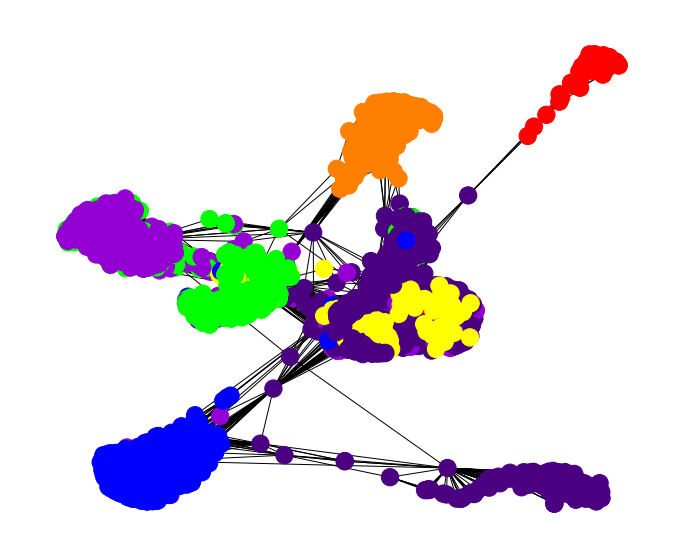

In [18]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(vecs[:,1:7])
labels = kmeans.labels_
print("Clusters:", labels)
fig = plt.subplots(1, figsize=(12,10))
colors = ['#9400D3', '#4B0082', '#0000FF', '#00FF00', '#FFFF00', '#FF7F00', '#FF0000']
node_colors = [ colors[labels[v]] for v in kn.nodes()]
nx.draw(kn, node_color=node_colors, with_labels=False)

Clusters: [1 1 1 ... 3 3 3]


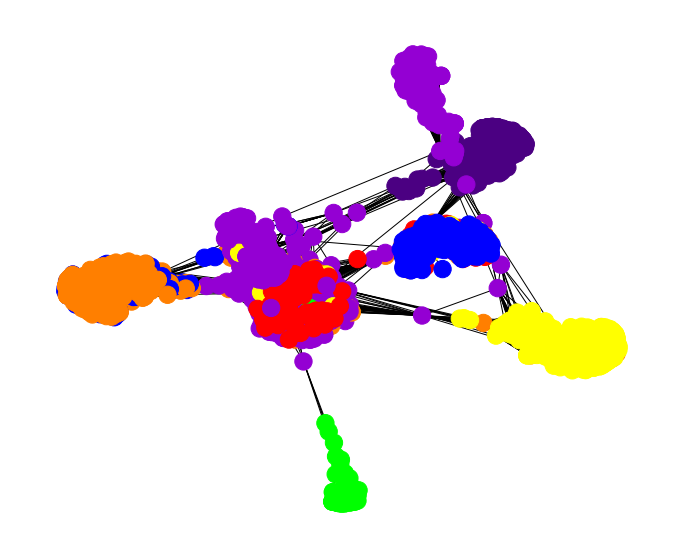

In [24]:
aggCl = AgglomerativeClustering(n_clusters=7)
aggCl.fit(vecs[:,1:7])
labels = aggCl.labels_
print("Clusters:", labels)
fig = plt.subplots(1, figsize=(12,10))
colors = ['#9400D3', '#4B0082', '#0000FF', '#00FF00', '#FFFF00', '#FF7F00', '#FF0000']
node_colors = [ colors[labels[v]] for v in kn.nodes()]
nx.draw(kn, node_color=node_colors, with_labels=False)

## Karate data : The Analysis

### Importing data and interpreting it into graph data mathematically

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges


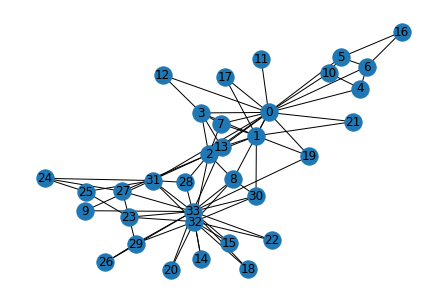

In [9]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network

# we have to take the data from existing file on local system
kn=nx.karate_club_graph()

print(kn)
nx.draw(kn, with_labels=True)

In [10]:
# data = pd.read_csv("soc-karate.mtx", sep=" ", header=None)
# data.columns = ["person1", "person2"]

# # sample = data.sample(1000, random_state=1)

# net = Network(notebook=True, cdn_resources="remote", bgcolor="#222222", font_color="white", height="750px", width="100%")

# nodes = list(set([*data.person1, *data.person2]))   # data == sample
# edges = data.values.tolist()   # data === sample
# net.add_nodes(nodes)
# net.add_edges(edges)
# net.show('graph.html')

### graph representation to adjacent matrix

In [11]:
adjM = nx.adjacency_matrix(kn, weight=1)   # assigning the edge weight to 1
print(adjM.todense())

print(kn.degree)

L = nx.laplacian_matrix(kn, weight=1).astype(float)  # assigning the edge weight to 1
print(L.todense())

[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]
[(0, 16), (1, 9), (2, 10), (3, 6), (4, 3), (5, 4), (6, 4), (7, 4), (8, 5), (9, 2), (10, 3), (11, 1), (12, 2), (13, 5), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 3), (20, 2), (21, 2), (22, 2), (23, 5), (24, 3), (25, 3), (26, 2), (27, 4), (28, 3), (29, 4), (30, 4), (31, 6), (32, 12), (33, 17)]
[[16. -1. -1. ... -1.  0.  0.]
 [-1.  9. -1. ...  0.  0.  0.]
 [-1. -1. 10. ...  0. -1.  0.]
 ...
 [-1.  0.  0. ...  6. -1. -1.]
 [ 0.  0. -1. ... -1. 12. -1.]
 [ 0.  0.  0. ... -1. -1. 17.]]


### feature extraction

In [14]:
graphs = [kn]

deg_cen = {}

for g in graphs:
    deg_cen[g] = nx.degree_centrality(g)

print('Degree Centrality: ')
print(deg_cen[g],'\n\n')

bet_cen = {}

for g in graphs:
    bet_cen[g] = nx.betweenness_centrality(g, normalized=True, endpoints=True)

print('Betweenness Centrality: ')
print(bet_cen[g], '\n\n')

eig_cen = {}

for g in graphs:
    eig_cen[g] = nx.eigenvector_centrality(g)

print('Eigenvector centrality: ')
print(eig_cen[g], '\n\n')

print("Sorted betweenness centrality nodeIDs : ", sorted(bet_cen[g], key=bet_cen[g].get, reverse=True)[:7])
print("Sorted degree      centrality nodeIDs : ", sorted(deg_cen[g], key=deg_cen[g].get, reverse=True)[:7])
print("Sorted eigenvector centrality nodeIDs : ", sorted(eig_cen[g], key=eig_cen[g].get, reverse=True)[:7])

Degree Centrality: 
{0: 0.48484848484848486, 1: 0.2727272727272727, 2: 0.30303030303030304, 3: 0.18181818181818182, 4: 0.09090909090909091, 5: 0.12121212121212122, 6: 0.12121212121212122, 7: 0.12121212121212122, 8: 0.15151515151515152, 9: 0.06060606060606061, 10: 0.09090909090909091, 11: 0.030303030303030304, 12: 0.06060606060606061, 13: 0.15151515151515152, 14: 0.06060606060606061, 15: 0.06060606060606061, 16: 0.06060606060606061, 17: 0.06060606060606061, 18: 0.06060606060606061, 19: 0.09090909090909091, 20: 0.06060606060606061, 21: 0.06060606060606061, 22: 0.06060606060606061, 23: 0.15151515151515152, 24: 0.09090909090909091, 25: 0.09090909090909091, 26: 0.06060606060606061, 27: 0.12121212121212122, 28: 0.09090909090909091, 29: 0.12121212121212122, 30: 0.12121212121212122, 31: 0.18181818181818182, 32: 0.36363636363636365, 33: 0.5151515151515151} 


Betweenness Centrality: 
{0: 0.4707155589508531, 1: 0.1095874713521772, 2: 0.19402993520640582, 3: 0.07003225532637297, 4: 0.059417706476

### clustering: k-means

Clusters: [3 3 3 3 0 0 0 3 1 1 0 2 3 3 1 1 0 3 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1]


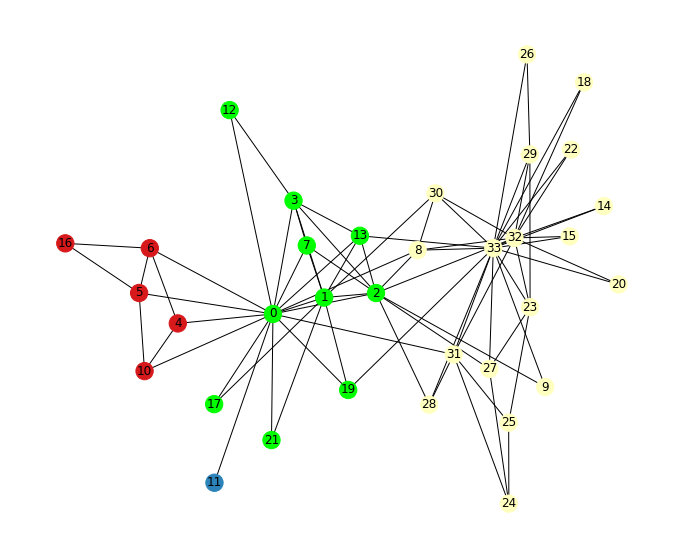

In [28]:
# the implementation is done using spectral decomposition

from sklearn.cluster import KMeans

vals, vecs = np.linalg.eig(L.todense())

# sort these based on the eigenvalues
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

# kmeans on first three vectors with nonzero eigenvalues
kmeans = KMeans(n_clusters=4)
kmeans.fit(vecs[:,1:4])
labels = kmeans.labels_
print("Clusters:", labels)
fig = plt.subplots(1, figsize=(12,10))
colors = ['#d7191c', '#ffffbf', '#2b83ba', '#00FF00']
node_colors = [ colors[labels[v]] for v in kn.nodes()]
nx.draw(kn, node_color=node_colors, with_labels='True')

Clusters: [ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]


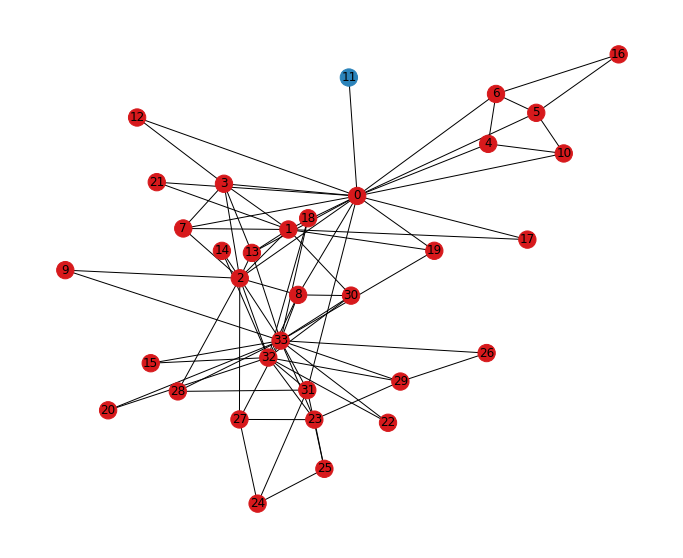

In [31]:
from sklearn.cluster import DBSCAN

# kmeans on first three vectors with nonzero eigenvalues
dbscan = DBSCAN(eps=0.5)
dbscan.fit(vecs[:,1:3])
labels = dbscan.labels_
print("Clusters:", labels)
fig = plt.subplots(1, figsize=(12,10))
colors = ['#d7191c', '#ffffbf', '#2b83ba']
node_colors = [ colors[labels[v]] for v in kn.nodes()]
nx.draw(kn, node_color=node_colors, with_labels='True')

Clusters: [0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


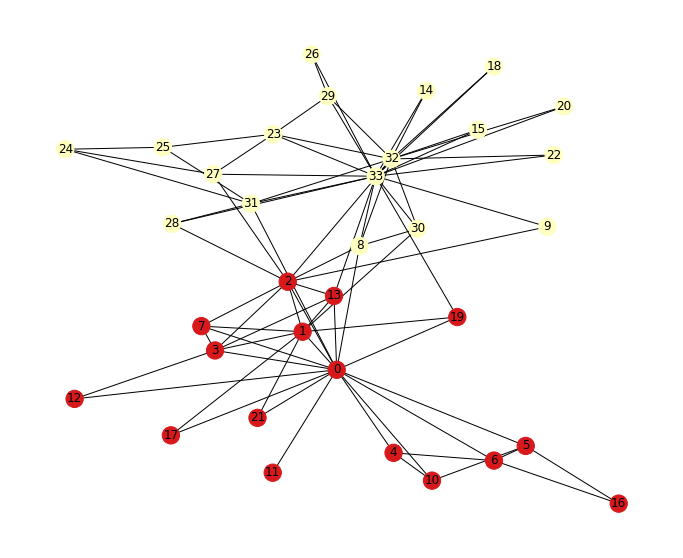

In [30]:
from sklearn.cluster import AgglomerativeClustering

# kmeans on first three vectors with nonzero eigenvalues
aggCl = AgglomerativeClustering(n_clusters=2)
aggCl.fit(vecs[:,1:2])
labels = aggCl.labels_
print("Clusters:", labels)
fig = plt.subplots(1, figsize=(12,10))
colors = ['#d7191c', '#ffffbf', '#2b83ba', '#00FF00']
node_colors = [ colors[labels[v]] for v in kn.nodes()]
nx.draw(kn, node_color=node_colors, with_labels='True')

#### Evalution metrics

In [18]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score

se = [] 
sil_scores = []
calinski_score = []
davies_score = []
index = range(2, 10)
for i in index:
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(vecs[:,1:i])
    se.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(vecs[:,1:i], labels))
    calinski_score.append(calinski_harabasz_score(vecs[:,1:i], labels))
    davies_score.append(davies_bouldin_score(vecs[:,1:i], labels))

    print('With in sum of squared error (WCSS) at K =', i, ':', kmeans.inertia_)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(vecs[:,1:i], labels))
    print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(vecs[:,1:i], labels))
    print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(vecs[:,1:i], labels))
    print("---------------------------------------------------------------")

With in sum of squared error (WCSS) at K = 2 : 0.2684721424657688
Silhouette Coefficient: 0.631
Calinski-Harabasz Index: 87.193
Davies-Bouldin Index: 0.517
---------------------------------------------------------------
With in sum of squared error (WCSS) at K = 3 : 0.5022151497981631
Silhouette Coefficient: 0.663
Calinski-Harabasz Index: 46.227
Davies-Bouldin Index: 0.329
---------------------------------------------------------------
With in sum of squared error (WCSS) at K = 4 : 0.3121237894643326
Silhouette Coefficient: 0.631
Calinski-Harabasz Index: 86.116
Davies-Bouldin Index: 0.340
---------------------------------------------------------------
With in sum of squared error (WCSS) at K = 5 : 0.5540094884668848
Silhouette Coefficient: 0.541
Calinski-Harabasz Index: 45.096
Davies-Bouldin Index: 0.489
---------------------------------------------------------------
With in sum of squared error (WCSS) at K = 6 : 0.7211828078095073
Silhouette Coefficient: 0.506
Calinski-Harabasz Index:

In [21]:
se = [] 
sil_scores = []
calinski_score = []
davies_score = []
index = range(2, 10)
for i in index:
    aggCl = AgglomerativeClustering(n_clusters=i)
    labels = aggCl.fit_predict(vecs[:,1:i])
    sil_scores.append(silhouette_score(vecs[:,1:i], labels))
    calinski_score.append(calinski_harabasz_score(vecs[:,1:i], labels))
    davies_score.append(davies_bouldin_score(vecs[:,1:i], labels))

    print('at K =', i, ':')
    print("Silhouette Coefficient: %0.3f" % silhouette_score(vecs[:,1:i], labels))
    print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(vecs[:,1:i], labels))
    print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(vecs[:,1:i], labels))
    print("---------------------------------------------------------------")

at K = 2 :
Silhouette Coefficient: 0.621
Calinski-Harabasz Index: 73.035
Davies-Bouldin Index: 0.523
---------------------------------------------------------------
at K = 3 :
Silhouette Coefficient: 0.663
Calinski-Harabasz Index: 46.227
Davies-Bouldin Index: 0.329
---------------------------------------------------------------
at K = 4 :
Silhouette Coefficient: 0.590
Calinski-Harabasz Index: 72.395
Davies-Bouldin Index: 0.388
---------------------------------------------------------------
at K = 5 :
Silhouette Coefficient: 0.552
Calinski-Harabasz Index: 45.094
Davies-Bouldin Index: 0.498
---------------------------------------------------------------
at K = 6 :
Silhouette Coefficient: 0.472
Calinski-Harabasz Index: 27.481
Davies-Bouldin Index: 0.553
---------------------------------------------------------------
at K = 7 :
Silhouette Coefficient: 0.436
Calinski-Harabasz Index: 17.813
Davies-Bouldin Index: 0.566
---------------------------------------------------------------
at K = 8 :